In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import math
%matplotlib inline

In [24]:
class Panel:
    def __init__(self, z1, z2):
        self.z1 = z1
        self.z2 = z2
        self.zc = (z1 + z2)*0.5
        self.length = abs(z2 - z1)
        self.angle = np.angle(z2 - z1)
        self.gamma = 0.0
        self.normal = np.exp(1.0j*(np.pi*0.5 + np.angle(z2 - z1)))
        if (z2.real - z2.imag)<0:
            self.angle = math.acos((z2.imag - z1.imag)/self.length)
        else:
            self.angle = math.pi + math.acos(-(z2.imag - z1.imag)/self.length)

In [25]:
def create_panels(N, R=1.0):
    panels = np.empty(N, dtype=object)
    theta = np.linspace(0, 2*np.pi, N+1)
    position = R * np.exp(1j*theta)
    for i in range(N):
        panels[i] = Panel(position[i], position[i+1])
    return panels

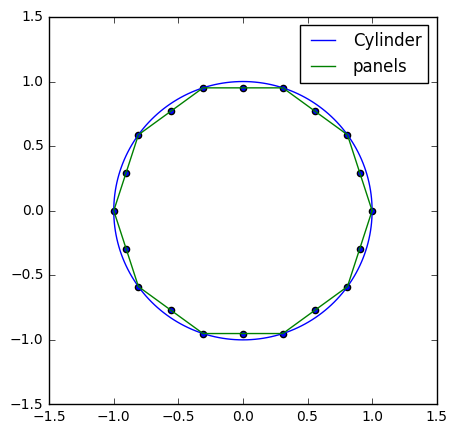

In [26]:
R = 1.0
panels = create_panels(N=10, R=1.0)
theta = np.linspace(0, 2*np.pi, 201)
x_cylinder = R*np.cos(theta)
y_cylinder = R*np.sin(theta)
plt.figure(figsize=(5,5))
plt.plot(x_cylinder, y_cylinder, label='Cylinder')
x = R*np.cos(np.linspace(0, 2*np.pi, 11))
y = R*np.sin(np.linspace(0, 2*np.pi, 11))
plt.plot(x, y, label='panels')
plt.scatter([p.z1.real for p in panels], [p.z1.imag for p in panels])
plt.scatter([p.zc.real for p in panels], [p.zc.imag for p in panels])
plt.legend()
plt.show()

In [27]:
def random_vortex_method(mu, nu, dt, N):
    sigma = np.sqrt(2*nu*dt)
    z = np.random.normal(mu, sigma, N) + 1j * np.random.normal(mu, sigma, N)
    return z

		

In [28]:
def compute_A(N=20, R=1.0):
    panels = create_panels(N=N, R=R)
    A = np.empty((N+1, N), dtype=float)
    np.fill_diagonal(A,0.0)
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            theta = cmath.phase(p_j.z2 - p_j.z1)
            theta1 = cmath.phase(panels[j-1].z2 - panels[j-1].z1)
            zr = (p_i.zc - p_j.z1)*np.exp(-1j*theta)
            zl = (p_i.zc - panels[j-1].z1)*np.exp(-1j*theta1)
            l = abs(p_i.z1 - p_i.z2)
            vel_l = np.conj((1j/(2.*np.pi))*(np.log((zl - l)/zl)*(zl/l) + 1.))*np.exp(1j*theta1)
            vel_r = np.conj((-1j/(2.*np.pi))*(np.log((zr - l)/zr)*(zr/l - 1.) + 1.))*np.exp(1j*theta)
            A[i][j] = ((vel_l + vel_r)*(np.exp(-1j*(p_i.angle - np.pi)))).real
            A[N,i] = 1.0
    return A

In [29]:
def compute_B(N, R, vortex_position, gamma_vortex, u_inf=1.0+0.0*1j, u_body=0.0+0.0*1j):
    panels = create_panels(N, R)
    B = np.zeros([N+1, 1], dtype=float)
    for i in range(N):
        u_body = (u_body.conjugate()*panels[i].normal).real
        u_freestream = (u_inf.conjugate()*panels[i].normal).real
        v = 0.0 + 0.0*1j
        for j,z_j in enumerate(vortex_position):
            v += vortex_velocity(panels[i].zc, vortex_position[j], gamma_vortex[j], 0.1)
        v = (v.conjugate()*panels[i].normal).real
        B[i] = u_body - u_freestream - v
    return B

In [30]:
def vortex_velocity(z, vor, gamma, delta):
    kr = get_kr(z, vor, delta)
    return (-1.0j*gamma/(2.0*np.pi*(z - vor))*kr).conjugate()

def get_kr(z, vor, delta):
    r = abs(z- vor)
    if r < delta:
        if r < 1e-10:
            return 0.0
        else:
            return r/delta
    else:
        return 1.0
    
def velocity_vortices(pos, gamma):
    vel = np.zeros_like(pos) + 1.0j*np.zeros_like(pos)
    for i, z_i in enumerate(pos):
        for j, z_j in enumerate(pos):
            if i!= j:
                vel[i] = vel[i] + vortex_velocity(z_i,z_j,gamma[j],0.1)
    return np.asarray(vel)

def velocity_panels(pos, panels):
    vel = np.zeros_like(pos) + 1.0j*np.zeros_like(pos)
    vel = []
    v = 0.0
    for i,z_i in enumerate(pos):
        for j,p_j in enumerate(panels):
            v = v + panel_velocity(panels, p_j, j, pos)
        vel.append(v)
    return np.asarray(vel)

def panel_velocity(panels, p_i, j, z):
    gamma = panels[j].gamma
    theta = np.angle(panels[j].z2 - panels[j].z1)
    theta1 = cmath.phase(panels[j-1].z2 - panels[j-1].z1)
    zr = (z - panels[j].z1)*np.exp(-1j*theta)
    zl = (z - panels[j-1].z1)*np.exp(-1j*theta1)
    l = abs(p_i.z1 - p_i.z2)
    vel_l = np.conj((1j/(2.*np.pi))*(np.log((zl - l)/zl)*(zl/l) + 1.))*np.exp(1j*theta1)
    vel_r = np.conj((-1j/(2.*np.pi))*(np.log((zr - l)/zr)*(zr/l - 1.) + 1.))*np.exp(1j*theta)
    return (vel_l + vel_r) * gamma


def point_velocities(Z,pos_vor,gamma_vor,panels_matrix,gamma_matrix):
    vel = np.zeros_like(Z) + 1.0j*np.zeros_like(Z)
    for ii,i in enumerate(Z):
        for jj,j in enumerate(i):
            for k,z_k in enumerate(pos_vor):
                vel[ii][jj] = vel[ii][jj] + vortex_velocity(j,z_k,gamma_vor[k],0.1)
            vel[ii] = vel[ii] + vortex_velocities_panels(i,panels_matrix,gamma_matrix)
    return vel

In [31]:
def reflect_blobs1(z, R):
    z1 = []
    for i in range(len(z)):
        #print z[0]
        if(abs(z[i] < R)):
            z1.append((2.0*R - abs(z))*np.exp(1.0j*np.angle(z)))
        else:
            z1.append(z[i])
    return z1


def reflect_vor2(diff,panel):
    x = []
    for z_i in diff:
        k1 = panel.z1.real*(panel.z2.imag - panel.z1.imag) - panel.z1.imag*(panel.z2.real - panel.z1.real)
        k2 = (panel.z1.real - z_i.real)*(panel.z2.imag - panel.z1.imag) - (panel.z1.imag - z_i.imag)*(panel.z2.real - panel.z1.real)
        if  k1*k2 > 0.0:
            angle = np.angle(panel.z2 - panel.z1)
            z_i_new = (z_i - panel.zc)*np.exp(-1.0j*angle)
            z_i = (z_i_new.conjugate())*np.exp(1.0j*angle) + panel.zc
            x.append(z_i)
        else:
            x.append(z_i)
    return np.array(x)

In [32]:
def flow_cylinder(dt=0.1, tf=3.0, R=1.0, N=50, Re=1000.0, u_inf=1.0+0.0*1j, gamma_max=0.1, mu=0.0):
    panels = create_panels(N, R)
    A = compute_A(N, R)
    vortex_position = []
    vor_mom = np.array([0.0])
    gamma_vortex = []
    nu = (2.0*abs(u_inf)*R/Re)
    t = 0.0
    T = []
    while t <= tf:
        B = compute_B(N, R, vortex_position, gamma_vortex, u_inf=1.0+0.0*1j, u_body=0.0+0.0*1j)
        gamma1 = np.linalg.lstsq(A,B)[0]
        for i,p in enumerate(panels):
            p.gamma = gamma1[i]
        #print gamma1
        vel = u_inf + velocity_vortices(vortex_position, gamma_vortex) + velocity_panels(vortex_position, panels)
        print velocity_panels(vortex_position, gamma_vortex)
        midpos = vortex_position + vel*dt/2.
        #print midpos
        midpos = reflect_blobs(midpos,R)
        B = compute_B(N, R, midpos, gamma_vortex, u_inf=1.0+0.0*1j, u_body=0.0+0.0*1j)
        gamma2 = np.linalg.lstsq(A,B)[0]
        for i,p in enumerate(panels):
            p.gamma = gamma2[i]
        midv = u_inf + velocity_vortices(midpos, gamma_vortex) + velocity_panels(midpos, panels)
        vortex_position = vortex_position + midv*dt
        vortex_position = reflect_blobs(vortex_position,R)
        for i,p_i in enumerate(panels):
            gamma3 = (panels[i].gamma + panels[i-1].gamma)*p_i.length/2.0
            if abs(gamma3) > gamma_max:
                nd = int(abs(gamma3)/gamma_max) + 1
                x = random_vortex_method(mu,nu,dt,nd) + p_i.zc
                x = reflect_vor2(x, p_i)	
                vortex_position = np.concatenate([vortex_position, x])
                gamma4 = gamma3/nd
                gamma_vortex = np.concatenate([gamma_vortex,np.full(len(x),gamma4)])

        for k in [3]:
            if abs(t - k) < 1e-9:
                positive_vortices = []
                negative_vortices = []
                for i,gam in enumerate(gamma_vortex):
                    if gam > 0:
                        positive_vortices.append(vortex_position[i])
                    else:
                        negative_vortices.append(vortex_position[i])

                positive_vortices = np.array(positive_vortices)
                negative_vortices = np.array(negative_vortices)
                plt.figure(figsize = (17.0,9.0))
                plt.plot(positive_vortices.real,positive_vortices.imag,"o")
                plt.plot(negative_vortices.real,negative_vortices.imag,"o")
                panel_x = []
                panel_y = []
                for panel in panels:
                    panel_x.append(panel.z1.real)
                    panel_y.append(panel.z1.imag)
                panel_x.append(panels[0].z1.real)
                panel_y.append(panels[0].z1.imag)
                plt.plot(panel_x,panel_y,label = 'Panels')
                plt.axis([-8.0,8.0,-4.0,4.0])
                plt.show()
                #plt.savefig('method1vor'+str(k)+'.png')
                #plt.close()	

        mom_ij = 0.0
        for i,z_i in enumerate(vortex_position):
            mom_ij = mom_ij + gamma_vortex[i]*z_i.imag
        vor_mom = np.concatenate([vor_mom,[mom_ij]])
        T.append(t)
        t = t + dt
        print t
        
flow_cylinder()

[]
0.1


AttributeError: 'numpy.float64' object has no attribute 'gamma'